In [3]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

['antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger',

## Model 1

In [25]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                       imgpath        labels
0        animals/animals\coyote\140e11d384.jpg        coyote
1           animals/animals\owl\4ee4d30847.jpg           owl
2   animals/animals\caterpillar\89eeb3fb5a.jpg   caterpillar
3  animals/animals\hippopotamus\5bbec0931a.jpg  hippopotamus
4           animals/animals\bee\1cb123c4e9.jpg           bee
(3780, 3)
----------Test--------------
                                 imgpath  labels
0   animals/animals\bison\50ec617e59.jpg   bison
1   animals/animals\bison\2fe9812e0d.jpg   bison
2     animals/animals\cat\2d7dc1ddb5.jpg     cat
3   animals/animals\horse\169c1bbbea.jpg   horse
4  animals/animals\possum\0d16effd0b.jpg  possum
(1620, 3)


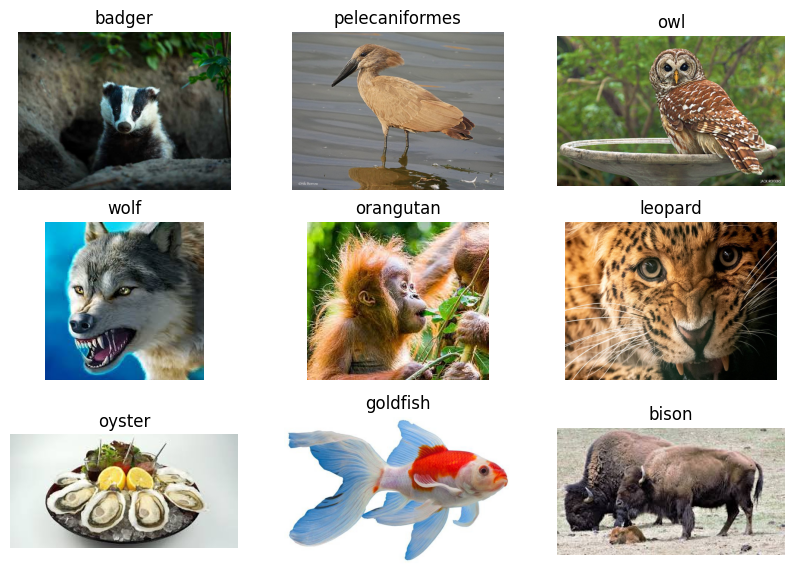

In [26]:
plt.figure(figsize=(10,7))
for i, row in test_df.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [27]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3780 validated image filenames belonging to 90 classes.
Found 1620 validated image filenames belonging to 90 classes.


In [28]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bottleneck=False):
    shortcut = x
    
    if use_bottleneck:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 6, 3]
    filters_list = [64, 128, 256, 512]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        stride = 1 if i == 0 else 2

        for j in range(num_blocks):
            x = residual_block(x, filters, stride=stride if j == 0 else 1, use_bottleneck=(j == 0 and i > 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='resnet')
    return model


# Example usage
input_shape = (224, 224, 3)  # Adjust input shape according to your needs
num_classes = 90 # Adjust number of classes as needed
resnet_model = ResNet(input_shape, num_classes)
resnet_model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_432 (Conv2D)         (None, 112, 112, 64)         9472      ['input_13[0][0]']            
                                                                                                  
 batch_normalization_432 (B  (None, 112, 112, 64)         256       ['conv2d_432[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_396 (Activation  (None, 112, 112, 64)         0         ['batch_normalization_432

In [30]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to store results
all_histories = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(train_df['imgpath'], train_df['labels'])):
    print(f'Fold {fold + 1}')

    generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

    # Split data into training and validation sets
    train_fold_df, val_fold_df = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # Reset indices
    train_fold_df = train_fold_df.reset_index(drop=True)
    val_fold_df = val_fold_df.reset_index(drop=True)

    # Data generators
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=val_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Initialize and compile the model
    resnet_model = ResNet(input_shape=(224, 224, 3), num_classes=90)  # Adjust num_classes as needed
    resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{fold + 1}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=200,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

    # Store history
    all_histories.append(history)

# Print average validation accuracy over all folds
avg_val_acc = np.mean([h.history['val_accuracy'][-1] for h in all_histories])
print(f'Average Validation Accuracy: {avg_val_acc * 100:.2f}%')

Fold 1
Found 3402 validated image filenames belonging to 90 classes.
Found 378 validated image filenames belonging to 90 classes.
Epoch 1/200
 21/213 [=>............................] - ETA: 4:57 - loss: 5.8902 - accuracy: 0.0089

KeyboardInterrupt: 

## MODEL 1 test

In [14]:
train_df, test_df = train_test_split(df, test_size=10, train_size=20, shuffle=True, random_state=124)

# Restablece los índices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                   imgpath    labels
0     animals/animals\otter\5d25066165.jpg     otter
1     animals/animals\hyena\9a4f9f93d0.jpg     hyena
2  animals/animals\seahorse\2c41217dae.jpg  seahorse
3      animals/animals\boar\3d28ab32a5.jpg      boar
4     animals/animals\koala\3f4b2076a8.jpg     koala
(20, 3)
----------Test--------------
                                 imgpath  labels
0   animals/animals\bison\50ec617e59.jpg   bison
1   animals/animals\bison\2fe9812e0d.jpg   bison
2     animals/animals\cat\2d7dc1ddb5.jpg     cat
3   animals/animals\horse\169c1bbbea.jpg   horse
4  animals/animals\possum\0d16effd0b.jpg  possum
(10, 3)


In [15]:
def residual_block(x, filters, kernel_size=3, stride=1, use_bottleneck=False):
    shortcut = x
    
    if use_bottleneck:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    num_blocks_list = [3, 4, 6, 3]
    filters_list = [64, 128, 256, 512]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        filters = filters_list[i]
        stride = 1 if i == 0 else 2

        for j in range(num_blocks):
            x = residual_block(x, filters, stride=stride if j == 0 else 1, use_bottleneck=(j == 0 and i > 0))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='resnet')
    return model


# Example usage
input_shape = (224, 224, 3)  # Adjust input shape according to your needs
num_classes = 10 # Adjust number of classes as needed
resnet_model = ResNet(input_shape, num_classes)
resnet_model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_144 (Conv2D)         (None, 112, 112, 64)         9472      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_144 (B  (None, 112, 112, 64)         256       ['conv2d_144[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_132 (Activation  (None, 112, 112, 64)         0         ['batch_normalization_144

In [16]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

generator_test= ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

test_images = generator_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Stratified K-Fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Variables to store results
all_histories = []

# Iterate through the folds
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(train_df['imgpath'], train_df['labels'])):
    print(f'Fold {fold + 1}')

    generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

    # Split data into training and validation sets
    train_fold_df, val_fold_df = train_df.iloc[train_idx], train_df.iloc[val_idx]

    # Reset indices
    train_fold_df = train_fold_df.reset_index(drop=True)
    val_fold_df = val_fold_df.reset_index(drop=True)

    # Data generators
    train_data_generator = generator.flow_from_dataframe(
        dataframe=train_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_data_generator = generator.flow_from_dataframe(
        dataframe=val_fold_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    # Initialize and compile the model
    resnet_model = ResNet(input_shape=(224, 224, 3), num_classes=10)  # Adjust num_classes as needed
    resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(f'resnet_fold_{fold + 1}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    history = resnet_model.fit(
        train_data_generator,
        validation_data=val_data_generator,
        epochs=5,  # Adjust as needed
        callbacks=[es, mc],
        verbose=1,
    )

    # Evaluate on the validation set
    val_loss, val_acc = resnet_model.evaluate(val_data_generator, verbose=1)
    print(f'Validation Accuracy: {val_acc * 100:.2f}%')

    # Store history
    all_histories.append(history)

# Print average validation accuracy over all folds
avg_val_acc = np.mean([h.history['val_accuracy'][-1] for h in all_histories])
print(f'Average Validation Accuracy: {avg_val_acc * 100:.2f}%')


Found 10 validated image filenames belonging to 8 classes.
Fold 1
Found 10 validated image filenames belonging to 10 classes.
Found 10 validated image filenames belonging to 10 classes.


c:\Users\DELL\Data_Mining\dataMining-env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.2768 - accuracy: 0.1000

c:\Users\DELL\Data_Mining\dataMining-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 14s 14s/step - loss: 3.2768 - accuracy: 0.1000 - val_loss: 7507.4180 - val_accuracy: 0.1000
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 1.3837 - accuracy: 0.4000 - val_loss: 38697.0352 - val_accuracy: 0.1000
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 4.8288 - accuracy: 0.6000 - val_loss: 142815.0781 - val_accuracy: 0.1000
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 1.8901 - accuracy: 0.6000 - val_loss: 512598.5000 - val_accuracy: 0.1000
Epoch 5/5
1/1 [==============================] - 1s 579ms/step - loss: 2124593.5000 - accuracy: 0.1000
Validation Accuracy: 10.00%
Fold 2
Found 10 validated image filenames belonging to 10 classes.
Found 10 validated image filenames belonging to 10 classes.
Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 3.1952 - accuracy: 0.2000

c:\Users\DELL\Data_Mining\dataMining-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 15s 15s/step - loss: 3.1952 - accuracy: 0.2000 - val_loss: 17524.1152 - val_accuracy: 0.1000
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 4.0138 - accuracy: 0.3000 - val_loss: 192409.2031 - val_accuracy: 0.1000
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 2.3034 - accuracy: 0.6000 - val_loss: 1494424.6250 - val_accuracy: 0.1000
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 1.3544 - accuracy: 0.7000 - val_loss: 5204413.5000 - val_accuracy: 0.1000
Epoch 5/5
1/1 [==============================] - 1s 550ms/step - loss: 10262994.0000 - accuracy: 0.1000
Validation Accuracy: 10.00%
Average Validation Accuracy: 10.00%
